Train a classifier and generate GradCAM's highlighting regions of each brain image important for diagnosis.

Run to limit usage to GPU #1 and 50% memory 

In [ ]:
# from armed.tfutils import set_gpu
# set_gpu(1, 0.5)

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

import tensorflow as tf
from armed.misc import expand_data_path, expand_results_path
from main import get_model

Select model type and output directory

In [5]:
strModelType = 'mixedeffects'
strOutputDir = expand_results_path('ad_classifier/re_slope_vis', make=True)

strWeightsPath = expand_results_path('ad_classifier/mixedeffects/split00_weights.h5')

Load data

In [6]:
# Data directory
strDataDir = expand_data_path('ADNI23_sMRI/right_hippocampus_slices_2pctnorm/coronal_MNI-6_numpy/12sites/split00')
dictDataTrain = np.load(os.path.join(strDataDir, 'data_train.npz'))
dictDataVal = np.load(os.path.join(strDataDir, 'data_val.npz'))
dictDataTest = np.load(os.path.join(strDataDir, 'data_test.npz'))
dictDataUnseen = np.load(os.path.join(strDataDir, 'data_unseen.npz'))

# Weight each class by 1 - class frequency
dictClassWeights = {0.: dictDataTrain['label'].mean(),
                    1.: 1 - dictDataTrain['label'].mean()}

if strModelType == 'conventional':    
    train_in = dictDataTrain['images']
    val_in = dictDataVal['images']
    test_in = dictDataTest['images']
    unseen_in = dictDataUnseen['images']
else:
    train_in = (dictDataTrain['images'], dictDataTrain['cluster'])
    val_in = (dictDataVal['images'], dictDataVal['cluster'])
    test_in = (dictDataTest['images'], dictDataTest['cluster'])
    unseen_in = (dictDataUnseen['images'], dictDataUnseen['cluster'])

Train model

In [7]:
model = get_model(strModelType, n_clusters=dictDataTrain['siteorder'].shape[0])
_ = model.predict(train_in, batch_size=32, steps=1)
        
# lsCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auroc', mode='max',
#                                                 patience=5, 
#                                                 restore_best_weights=True)]
    
# model.fit(x=train_in,
#         y=dictDataTrain['label'],
#         batch_size=32,
#         epochs=20,
#         verbose=1,
#         class_weight=dictClassWeights,
#         callbacks=lsCallbacks,
#         validation_data=(val_in, dictDataVal['label']))
model.load_weights(strWeightsPath, skip_mismatch=True, by_name=True)

2022-03-03 14:57:11.587879: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-03-03 14:57:12.781879: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-03 14:57:14.515600: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


GradCAM functions

In [8]:
def gradcam(inputs):
    
    with tf.GradientTape() as gt:
        if strModelType == 'adversarial':
            outputs = model.classifier.call(inputs, return_layer_activations=True)
        else:
            outputs = model.call(inputs, return_layer_activations=True)
        pred = outputs[-1]
        conv = outputs[-4] #2nd to last convolutional layer output

    grads = gt.gradient(pred, conv)
    gradsPooled = tf.reduce_max(grads, axis=(0, 1, 2))
    heatmap = conv[0] @ gradsPooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    arrHeatmap = tf.maximum(heatmap, 0).numpy()
    arrHeatmap -= arrHeatmap.min()
    arrHeatmap /= arrHeatmap.max()
    return arrHeatmap
 
def superimpose(img, heatmap):
    # Superimpose the heatmap on the original image using the jet colormap.
    heatmap = np.uint8(255 * heatmap)
        
    jet = cm.get_cmap('jet')
    arrColors = jet(np.arange(256))[:, :3]
    arrHeatmapJet = arrColors[heatmap]
    arrHeatmapJet = cv2.resize(arrHeatmapJet, img.squeeze().shape)

    arrSuper = arrHeatmapJet * 0.75 + img    
    return arrSuper.squeeze() / arrSuper.max()

Create GradCAM's for 3 images from each site.

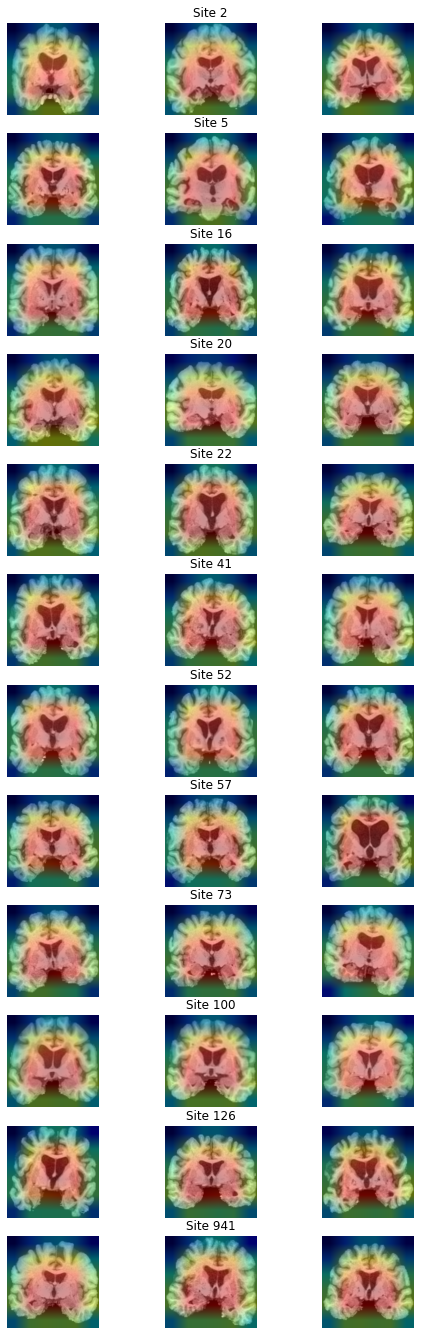

In [9]:
nSites = dictDataTrain['siteorder'].shape[0]
nImagesPerSite = 3
fig, ax = plt.subplots( nSites, nImagesPerSite, figsize=(8, nSites*2))
for iSite in range(nSites):
    site = dictDataTrain['siteorder'][iSite]
    arrSiteImages = dictDataTrain['images'][dictDataTrain['cluster'][:, iSite] == 1]
    np.random.seed(38)
    arrSelectIdx = np.random.choice(np.arange(arrSiteImages.shape[0]), nImagesPerSite)
    for iImage in range(nImagesPerSite):
        img = arrSiteImages[arrSelectIdx[iImage],]
        if strModelType in ['clusterinput', 'randomeffects', 'mixedeffects']:
            z = np.zeros((1, nSites), dtype=np.float32)
            z[:, iSite] = 1
            cam = gradcam((np.expand_dims(img, 0), z))
        else:
            cam = gradcam(np.expand_dims(img, 0))
        overlaid = superimpose(img, cam)
        ax[iSite, iImage].imshow(overlaid)
        ax[iSite, iImage].axis('off')
        
    ax[iSite, 1].set_title(f'Site {site}')

fig.savefig(os.path.join(strOutputDir, strModelType + '_gradcam.png'))
fig.savefig(os.path.join(strOutputDir, strModelType + '_gradcam.svg'))

Generate Grad-CAMs of the random effects subnetwork. This is done indirectly by computing Grad-CAMs for the full model and FE subnetwork, then taking the difference. Using the same 5 subjects, generate these difference Grad-CAMs with various site-specific random effects applied. 

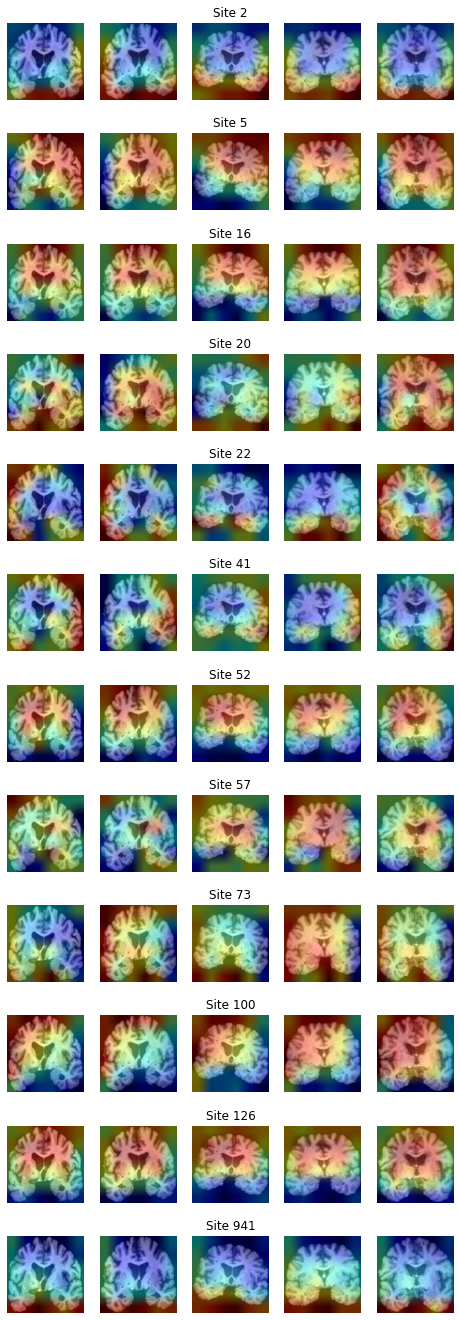

In [35]:
if strModelType in ['clusterinput', 'randomeffects', 'mixedeffects']:
    nSites = dictDataTrain['siteorder'].shape[0]  
    nImagesAD = 2
    nImagesCN = 3
    arrImagesAD = dictDataTrain['images'][dictDataTrain['label'] == 1,]
    arrImagesCN = dictDataTrain['images'][dictDataTrain['label'] == 0,]
    np.random.seed(799)
    arrSelectIDXAD = np.random.choice(np.arange(arrImagesAD.shape[0]), nImagesAD)
    arrSelectIDXCN = np.random.choice(np.arange(arrImagesCN.shape[0]), nImagesCN)
    arrImages = np.concatenate([arrImagesAD[arrSelectIDXAD], arrImagesCN[arrSelectIDXCN]])
    
    fig, ax = plt.subplots( nSites, nImagesAD + nImagesCN, figsize=(8, nSites*2))
    for iSite in range(nSites):
        site = dictDataTrain['siteorder'][iSite]
        
        for iImage in range(nImagesAD + nImagesCN):
            img = arrImages[iImage,]
            z = np.zeros((1, nSites), dtype=np.float32)
            z[:, iSite] = 1
            camOrig = gradcam((np.expand_dims(img, 0), z))
            camFE = gradcam((np.expand_dims(img, 0), np.zeros_like(z)))
            cam = camOrig - camFE
            cam -= cam.min()
            cam /= cam.max()
            
            # cam = gradcam((np.expand_dims(img, 0), z))
                            
            overlaid = superimpose(img, cam)
            ax[iSite, iImage].imshow(overlaid)
            ax[iSite, iImage].axis('off')
                            
        ax[iSite, 2].set_title(f'Site {site}')
        
    fig.savefig(os.path.join(strOutputDir, strModelType + '_gradcam_me_minus_fe_samesubjects.png'))
    fig.savefig(os.path.join(strOutputDir, strModelType + '_gradcam_me_minus_fe_samesubjects.svg'))